### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
class Config:
    pass

CONFIG = Config()
CONFIG.mnist_path = None
CONFIG.batch_size = 16
CONFIG.num_workers = 3
CONFIG.num_epochs = 10
CONFIG.noise_size = 50
CONFIG.print_freq = 500
CONFIG.learning_rate = 0.0002

In [3]:
dataset = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8679390.25it/s] 


Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 68684.58it/s]


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2616137.81it/s]


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9141522.86it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(dataset, batch_size=CONFIG.batch_size, shuffle=True)
len(dataloader)

3750

In [5]:
image, label = next(iter(dataloader))
image.size()

torch.Size([16, 1, 28, 28])

### Создаем модель GAN

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.model(x)
        out = out.view(x.size(0), 1, 28, 28)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out

In [7]:
GENERATOR = Generator()
DISCRIMINATOR = Discriminator()

In [8]:
GENERATOR

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [9]:
DISCRIMINATOR

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [11]:
def train(generator, discriminator, dataloader, num_epochs, lr, device):
    discriminator.to(device)
    generator.to(device)

    criterion = nn.BCEWithLogitsLoss()

    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            noise = torch.randn(batch_size, 100).to(device)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Train the discriminator
            discriminator.zero_grad()
            real_outputs = discriminator(real_images)
            d_loss_real = criterion(real_outputs, real_labels)

            z = torch.randn(batch_size, 100).to(device)
            fake_images = generator(z)
            fake_outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_outputs, fake_labels)

            d_loss = d_loss_real + d_loss_fake

            # Compute gradient penalty
            alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
            interpolated_images = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
            interpolated_outputs = discriminator(interpolated_images)

            gradients = torch.autograd.grad(outputs=interpolated_outputs, inputs=interpolated_images,
                             grad_outputs=torch.ones(interpolated_outputs.size()).to(device),
                             create_graph=True, retain_graph=True)[0]

            gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)

            d_loss += 10 * gradient_penalty

            d_loss.backward()
            d_optimizer.step()
            ###

            # Train the generator
            generator.zero_grad()

            fake_images = generator(noise)
            fake_outputs = discriminator(fake_images)
            g_loss = criterion(fake_outputs, real_labels)

            g_loss.backward()
            g_optimizer.step()

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

In [12]:
torch.manual_seed(42)

In [13]:
train(GENERATOR, DISCRIMINATOR, dataloader, num_epochs=CONFIG.num_epochs, lr=CONFIG.learning_rate, device=DEVICE)

Epoch [1/10], Step [100/3750], d_loss: 10.6229, g_loss: 0.5992
Epoch [1/10], Step [200/3750], d_loss: 8.8698, g_loss: 5.0378
Epoch [1/10], Step [300/3750], d_loss: 8.8199, g_loss: 4.4085
Epoch [1/10], Step [400/3750], d_loss: 8.8036, g_loss: 8.2350
Epoch [1/10], Step [500/3750], d_loss: 7.9271, g_loss: 6.8941
Epoch [1/10], Step [600/3750], d_loss: 7.3132, g_loss: 8.3522
Epoch [1/10], Step [700/3750], d_loss: 6.6693, g_loss: 10.1407
Epoch [1/10], Step [800/3750], d_loss: 6.0422, g_loss: 12.5254
Epoch [1/10], Step [900/3750], d_loss: 6.6865, g_loss: 5.3429
Epoch [1/10], Step [1000/3750], d_loss: 7.8919, g_loss: 7.3569
Epoch [1/10], Step [1100/3750], d_loss: 4.8892, g_loss: 5.8715
Epoch [1/10], Step [1200/3750], d_loss: 7.4001, g_loss: 5.4082
Epoch [1/10], Step [1300/3750], d_loss: 6.0145, g_loss: 3.5457
Epoch [1/10], Step [1400/3750], d_loss: 4.7727, g_loss: 4.5188
Epoch [1/10], Step [1500/3750], d_loss: 4.3500, g_loss: 4.0421
Epoch [1/10], Step [1600/3750], d_loss: 3.9980, g_loss: 3.658

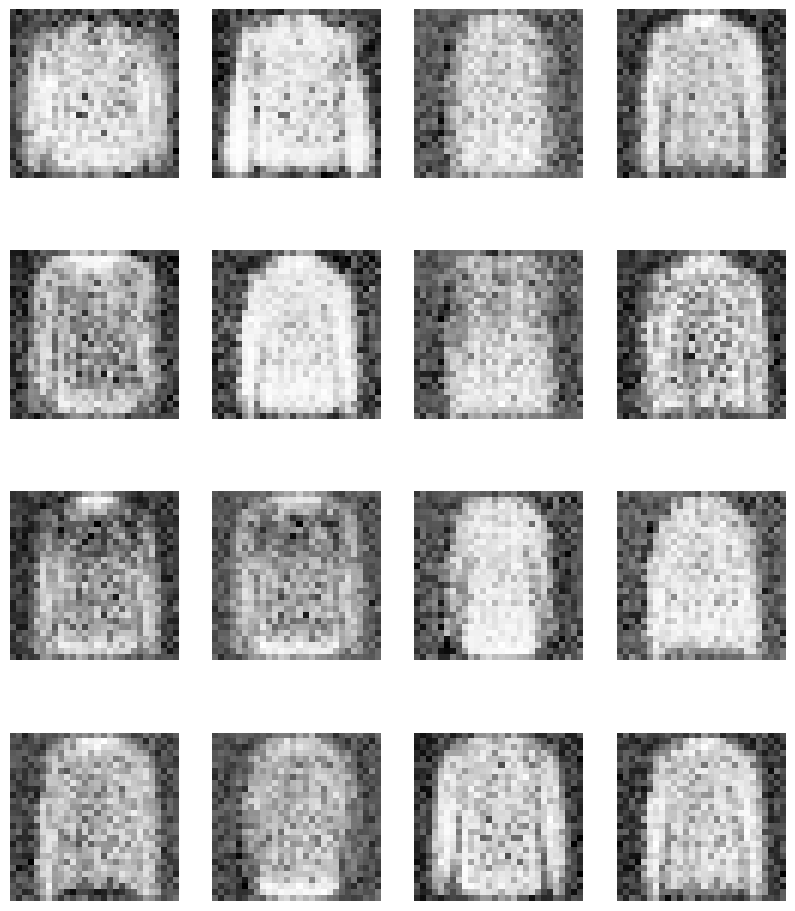

In [14]:
IMG_QTY = 16
IMG_SIZE = int(math.sqrt(IMG_QTY))

noise = torch.randn(IMG_QTY, 100, device=DEVICE)  # Generate 10 random noise vectors
generated_images = GENERATOR(noise)  # Generate images using the generator

plt.figure(figsize=(10, 12))
for i in range(IMG_QTY):
    plt.subplot(IMG_SIZE, IMG_SIZE, i+1)
    plt.imshow(generated_images[i].cpu().detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis("off")